In [1]:

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2024-02-10 04:51:17.203999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 04:51:17.204101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 04:51:17.486733: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found GPU at: /device:GPU:0


In [2]:
pip install imutils

  Preparing metadata (setup.py) ... - \ done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=dccc3f71eb74c538485d5f78c9aa803146a656e015ffa113021db7c1bfa13a8c
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [3]:
from tensorflow.keras.layers import Input, concatenate, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from skimage.transform import resize
import os
import csv
import PIL
import numpy as np
import random
import cv2
import imutils
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

In [4]:
HEIGHT = 240
WIDTH = 320
INIT_LR = 0.0001
EPOCHS = 15
TRAIN_PATH = "./data/nyu2_train.csv"
TEST_PATH = "./data/nyu2_test.csv"

In [5]:
def downsampling_block(input_tensor, n_filters):
  x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(input_tensor)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  return x

def upsampling_block(input_tensor, n_filters, name, concat_with):
  x = UpSampling2D((2, 2), interpolation='bilinear', name=name)(input_tensor)
  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convA")(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = concatenate([x, concat_with], axis=3)

  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convB")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convC")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  return x

In [6]:
def build(height, width, depth):
  # input
  i = Input(shape=(height, width, depth))

  resnet50 = ResNet50(include_top = False, weights = "imagenet", input_tensor = i)
  resnet50.summary()

  # encoder
#   conv1 = downsampling_block(i, 32)
#   pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#   conv2 = downsampling_block(pool1, 64)
#   pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#   conv3 = downsampling_block(pool2, 128)
#   pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#   conv4 = downsampling_block(pool3, 256)
#   pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

  conv1 = resnet50.get_layer("input_1").output
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = resnet50.get_layer("conv1_relu").output
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = resnet50.get_layer("conv2_block3_out").output
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = resnet50.get_layer("conv3_block4_out").output
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  

  # bottleneck
  conv5 = resnet50.get_layer("conv4_block6_out").output
  conv5 = LeakyReLU(alpha=0.2)(conv5)
  conv5 = resnet50.get_layer("conv4_block6_out").output
  conv5 = LeakyReLU(alpha=0.2)(conv5)

  # decoder
  conv6 = upsampling_block(conv5, 256, "up1", concat_with=conv4)
  conv7 = upsampling_block(conv6, 128, "up2", concat_with=conv3)
  conv8 = upsampling_block(conv7, 64, "up3", concat_with=conv2)
  conv9 = upsampling_block(conv8, 32, "up4", concat_with=conv1)

  # output
  o = Conv2D(filters=1, kernel_size=3, strides=(1,1), activation='sigmoid', padding='same', name='conv10')(conv9)

  model = Model(inputs=i, outputs=o)
  return model

In [7]:
model = build(HEIGHT, WIDTH, 3)

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 320, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 246, 326, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 120, 160, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 120, 160, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [8]:
model.summary()
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='./model.png')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 320, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 246, 326, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 120, 160, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 120, 160, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [9]:
!git clone https://gitlab.com/siddinc/new_depth.git ./data

Cloning into './data'...
remote: Enumerating objects: 65371, done.
remote: Counting objects: 100% (65371/65371), done.
remote: Compressing objects: 100% (65369/65369), done.
remote: Total 65371 (delta 2), reused 65371 (delta 2), pack-reused 0
Receiving objects: 100% (65371/65371), 2.79 GiB | 60.58 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (65418/65418), done.


In [10]:
# loading the dataset

def read_csv(csv_file_path):
  with open(csv_file_path, 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    return [('./' + row[0], './' + row[1]) for row in csv_reader if len(row) > 0]

def train_val_split(train_paths, val_size):
  random.shuffle(train_paths)
  len_train_paths = len(train_paths)
  i = int(len_train_paths*(1.0 - val_size))
  train = train_paths[0:i]
  val = train_paths[i:len(train_paths)]
  return train, val

def load_train_paths(train_path):
  train_paths = read_csv(train_path)
  labels = {img_path: dm_path for img_path, dm_path in train_paths}
  x_paths = [img_path for img_path, dm in train_paths]
  x_train_paths, x_val_paths = train_val_split(x_paths, 0.3)

  partition = {
    'train': x_train_paths,
    'validation': x_val_paths
  }
  return partition, labels

In [11]:
# preprocessing the dataset

def normalize_img(img):
    norm_img = (img - img.min()) / (img.max() - img.min())
    return norm_img

def preprocess_image(img_path, horizontal_flip=False):
  image = cv2.imread(img_path)
  image = imutils.resize(image, height=HEIGHT)
  # image = image[:, 21:149].astype("float")
  image = image.astype("float")
  image = normalize_img(image)

  if horizontal_flip:
    image = cv2.flip(image, 1)
  return image

def preprocess_depth_map(depth_map_path, horizontal_flip=False):
  depth_map = cv2.imread(depth_map_path)
  depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2GRAY)
  depth_map = imutils.resize(depth_map, height=HEIGHT)
  # depth_map = depth_map[:, 21:149].astype("float")
  depth_map = depth_map.astype("float")
  depth_map = normalize_img(depth_map)

  if horizontal_flip:
    depth_map = cv2.flip(depth_map, 1)

  depth_map = np.reshape(depth_map, (depth_map.shape[0], depth_map.shape[1], 1))
  return depth_map

In [12]:
# data generator

from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
  def __init__(self, list_IDs, labels, batch_size=16, dim=(128,128), n_channels=3, shuffle=True, pred=False):
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    self.shuffle = shuffle
    self.pred = pred
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    list_IDs_temp = [self.list_IDs[k] for k in indexes]
    if self.pred:
      X = self.__data_generation(list_IDs_temp)
      return X
    X, y = self.__data_generation(list_IDs_temp)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, self.dim[0], self.dim[1],self.n_channels))

    if not self.pred:
      y = np.empty((self.batch_size, self.dim[0], self.dim[1], 1))

      for i, ID in enumerate(list_IDs_temp):
        res = random.choice([True, False])
        X[i,] = preprocess_image(ID, res)
        y[i,] = preprocess_depth_map(self.labels[ID], res)
      return X, y
    else:
      for i, ID in enumerate(list_IDs_temp):
        res = random.choice([True, False])
        X[i,] = preprocess_image(ID, res)
      return X

In [13]:
partition, labels = load_train_paths(TRAIN_PATH)

In [14]:
print(len(partition['train']), len(partition['validation']))

22437 9617


In [15]:
training_generator = DataGenerator(list_IDs=partition['train'], labels=labels, batch_size=16, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)
validation_generator = DataGenerator(list_IDs=partition['validation'], labels=labels, batch_size=16, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)

In [16]:
def poly_decay(epoch):
  maxEpochs = EPOCHS
  baseLR = INIT_LR
  power = 1.0
  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

opt = Adam(lr=INIT_LR, amsgrad=True)
callbacks = [LearningRateScheduler(poly_decay)]

# custom loss
def depth_loss(y_true, y_pred):
  w1, w2, w3 = 1.0, 1.0, 0.1

  l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)

  dy_true, dx_true = tf.image.image_gradients(y_true)
  dy_pred, dx_pred = tf.image.image_gradients(y_pred)
  l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

  l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

  return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

#custom soft accuracy
def depth_acc(y_true, y_pred):
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [17]:
model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])

In [18]:
r = model.fit(training_generator, validation_data=validation_generator, epochs=15, callbacks=callbacks)

Epoch 1/15


I0000 00:00:1707540820.432418      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1402/1402 [==============================] - 1043s 693ms/step - loss: 0.1305 - depth_acc: 0.8471 - val_loss: 0.1035 - val_depth_acc: 0.8874 - lr: 1.0000e-04
Epoch 2/15
1402/1402 [==============================] - 971s 692ms/step - loss: 0.0973 - depth_acc: 0.8951 - val_loss: 0.0897 - val_depth_acc: 0.9084 - lr: 9.3333e-05
Epoch 3/15
1402/1402 [==============================] - 970s 692ms/step - loss: 0.0853 - depth_acc: 0.9120 - val_loss: 0.0801 - val_depth_acc: 0.9209 - lr: 8.6667e-05
Epoch 4/15
1402/1402 [==============================] - 970s 692ms/step - loss: 0.0779 - depth_acc: 0.9215 - val_loss: 0.0773 - val_depth_acc: 0.9199 - lr: 8.0000e-05
Epoch 5/15
1402/1402 [==============================] - 970s 692ms/step - loss: 0.0732 - depth_acc: 0.9271 - val_loss: 0.0712 - val_depth_acc: 0.9340 - lr: 7.3333e-05
Epoch 6/15
1402/1402 [==============================] - 971s 692ms/step - loss: 0.0695 - depth_acc: 0.9313 - val_loss: 0.0714 - val_depth_acc: 0.9325 - lr: 6.6667e-05
Epoch 7/

In [19]:
model.save("resnet_unet_15.keras")

In [20]:
# model.load_weights("/kaggle/input/unet-resnet-nyu-model-5/unet_resnet_nyu_model.keras")

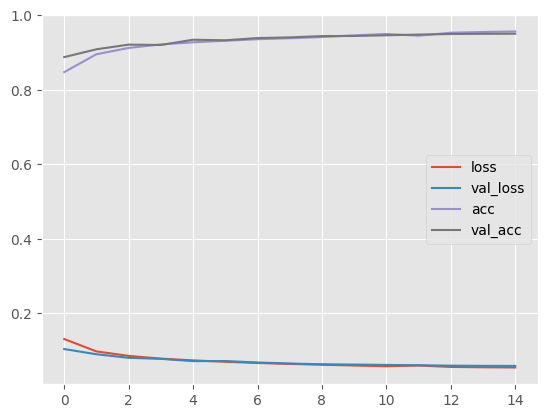

In [21]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# e = np.linspace(1, EPOCHS, num=EPOCHS)

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')

plt.plot(r.history['depth_acc'], label='acc')
plt.plot(r.history['val_depth_acc'], label='val_acc')

plt.legend()
plt.show()

In [22]:
img_dm_pairs = read_csv('./data/nyu2_test.csv')
labels = {i: j for i,j in img_dm_pairs}
test_paths = [i for i,j in img_dm_pairs]
print(len(test_paths))
partition = {'test': test_paths}

654


In [23]:
x_test = np.empty((len(test_paths), HEIGHT, WIDTH, 3))
y_test = np.empty((len(test_paths), HEIGHT, WIDTH, 1))

for i, ID in enumerate(partition['test'][:]):
  x_test[i, ] = preprocess_image(ID, horizontal_flip=False)
  y_test[i, ] = preprocess_depth_map(labels[ID], horizontal_flip=False)

In [24]:
print(model.evaluate(x_test, y_test))

21/21 [==============================] - 43s 953ms/step - loss: 0.1676 - depth_acc: 0.8036
[0.16763368248939514, 0.8036114573478699]


21/21 [==============================] - 8s 348ms/step


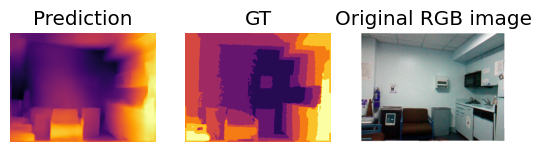

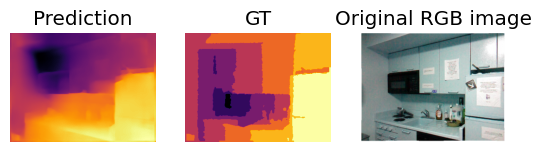

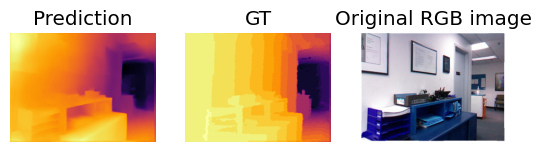

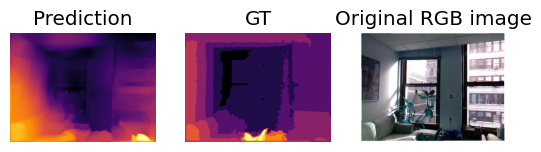

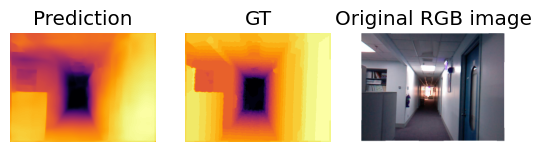

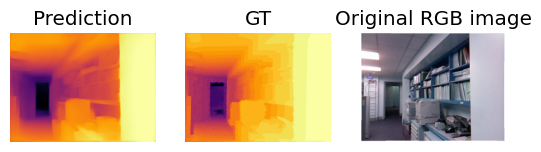

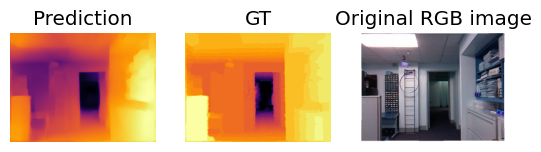

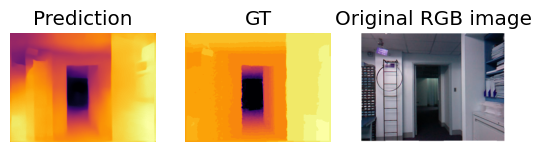

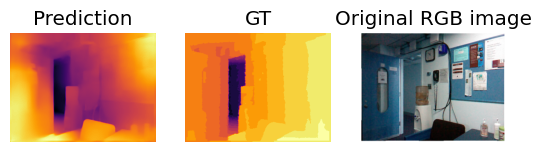

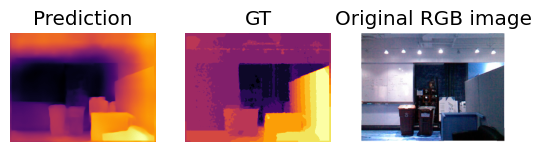

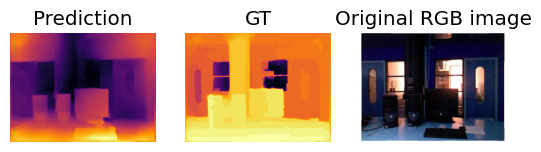

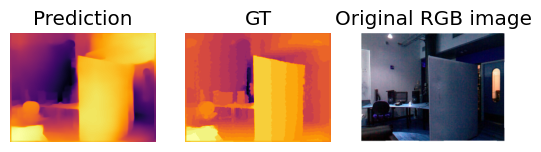

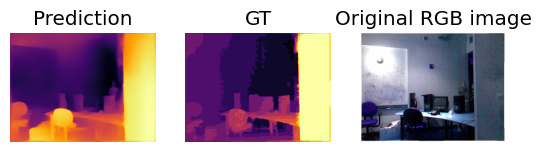

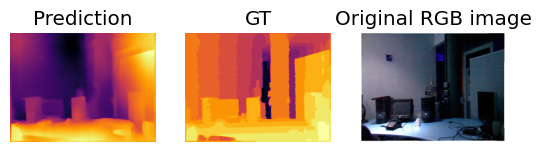

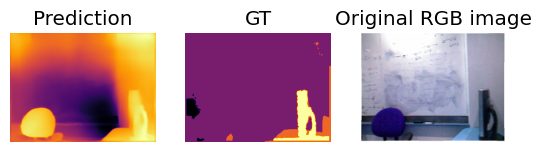

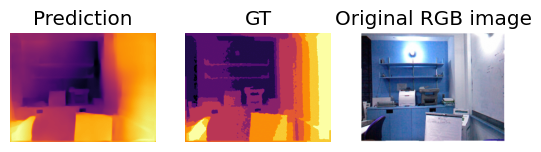

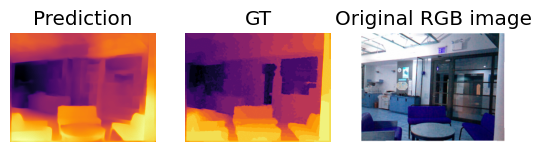

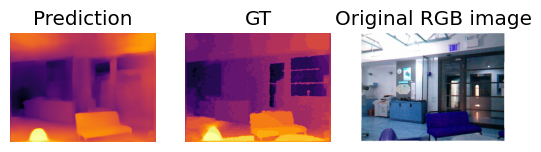

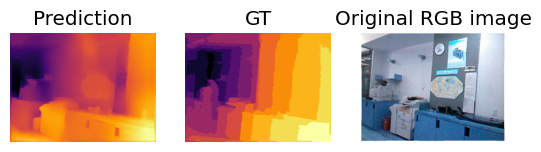

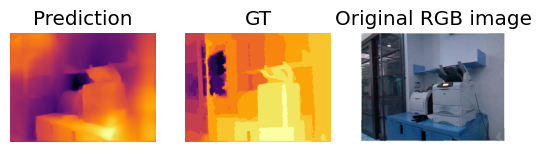

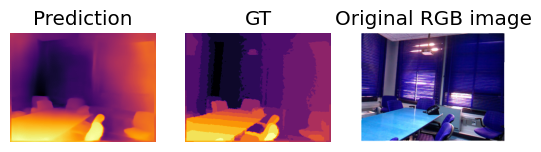

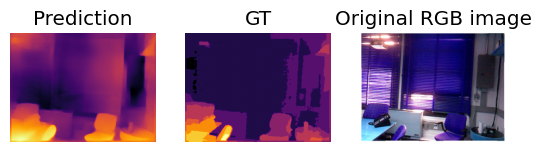

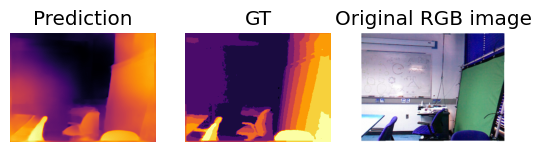

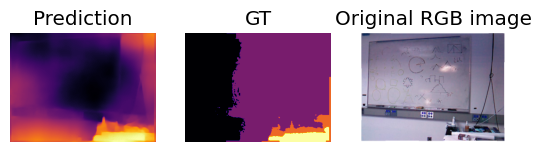

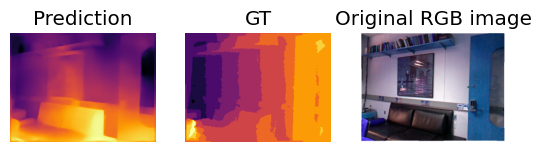

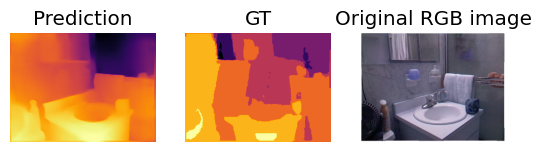

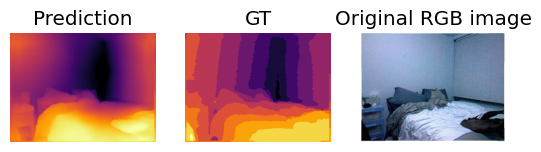

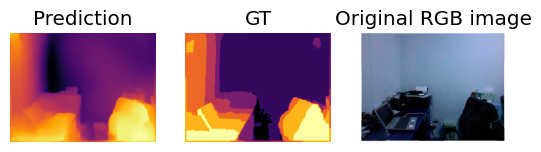

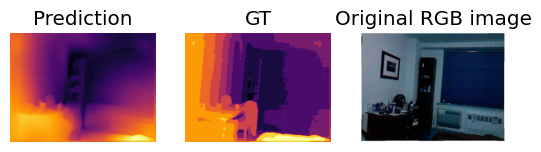

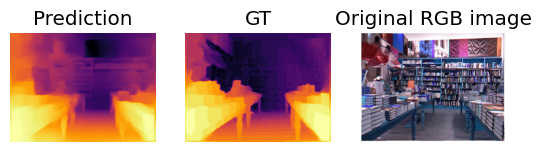

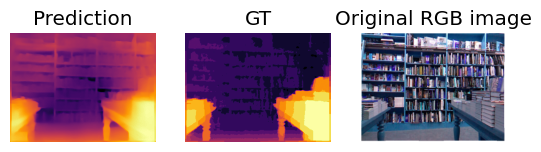

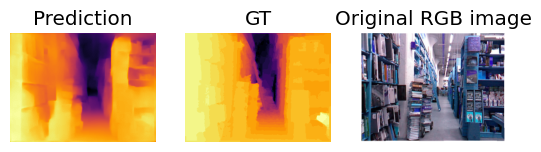

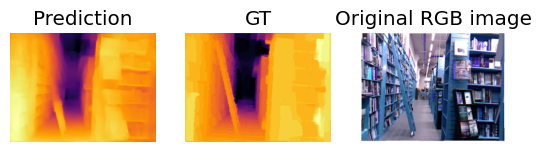

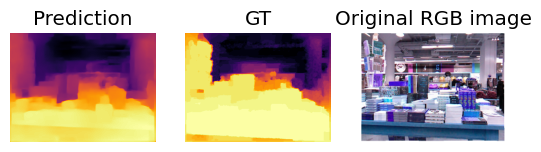

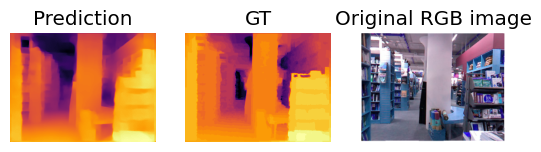

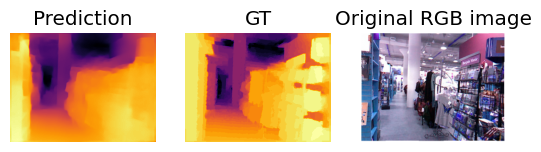

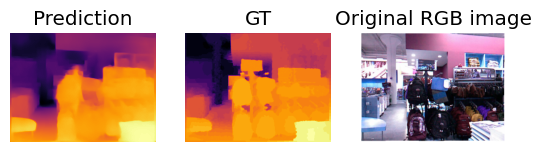

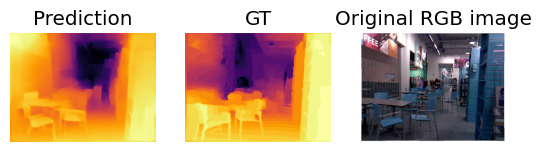

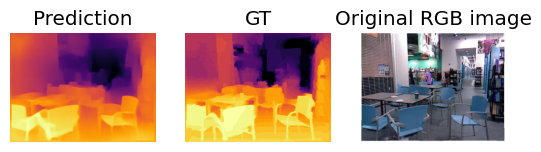

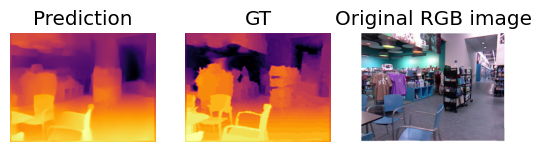

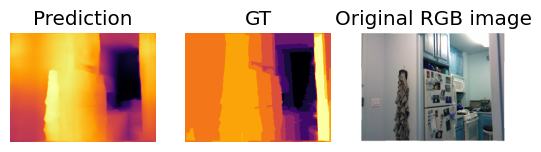

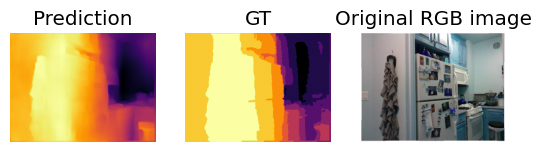

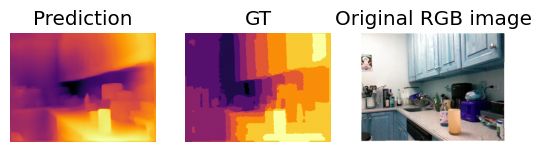

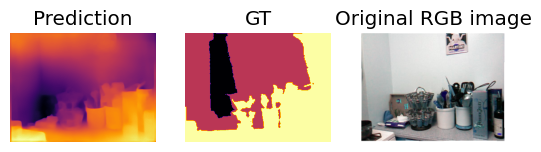

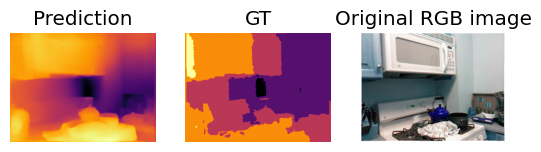

In [25]:
import matplotlib.pyplot as plt
import numpy as np

preds = model.predict(x_test)

for i in range(len(test_paths)-600):
  path = partition['test'][i]
  label_path = labels[path]
  pred = preds[i]
  pred = np.squeeze(pred, axis=-1)

  plt.subplot(1,3,1)
  plt.axis("off")
  plt.title("Prediction")
  plt.imshow(pred, cmap=plt.get_cmap('inferno_r'))

  plt.subplot(1,3,2)
  plt.axis("off")
  plt.title("GT")
  img = preprocess_depth_map(label_path, horizontal_flip=False)
  img = np.squeeze(img, axis=-1)
  plt.imshow(img, cmap=plt.get_cmap('inferno_r'))

  plt.subplot(1,3,3)
  plt.axis("off")
  plt.title("Original RGB image")
  img1 = preprocess_image(path, horizontal_flip=False)
  plt.imshow(img1)

  plt.show()